# Energy system optimisation with oemof

## Import modules

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

from oemof.solph import Sink, Source, Transformer, Bus, Flow, EnergySystem, Model
from oemof.solph.components import GenericStorage
import oemof.outputlib as outputlib

%matplotlib inline

## Specify solver

In [29]:
solver = 'cbc'

## Create an energy system and load data

In [30]:
datetimeindex = pd.date_range('1/1/2016', periods=24*365, freq='H')


In [31]:
energysystem = EnergySystem(timeindex=datetimeindex)
datetimeindex

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-30 14:00:00', '2016-12-30 15:00:00',
               '2016-12-30 16:00:00', '2016-12-30 17:00:00',
               '2016-12-30 18:00:00', '2016-12-30 19:00:00',
               '2016-12-30 20:00:00', '2016-12-30 21:00:00',
               '2016-12-30 22:00:00', '2016-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

In [32]:
filename = 'input_data.csv'
data = pd.read_csv(filename, sep=",")
data.head()

,Unnamed: 0,demand_th,demand_el,wind,pv
0,0,0.146945,0.613761,0.236754,0.0
1,1,0.150044,0.613761,0.240720,0.0
2,2,0.156926,0.557561,0.327421,0.0
3,3,0.174050,0.531738,0.402503,0.0
4,4,0.217514,0.519880,0.428876,0.0


## We want to build this energysystem

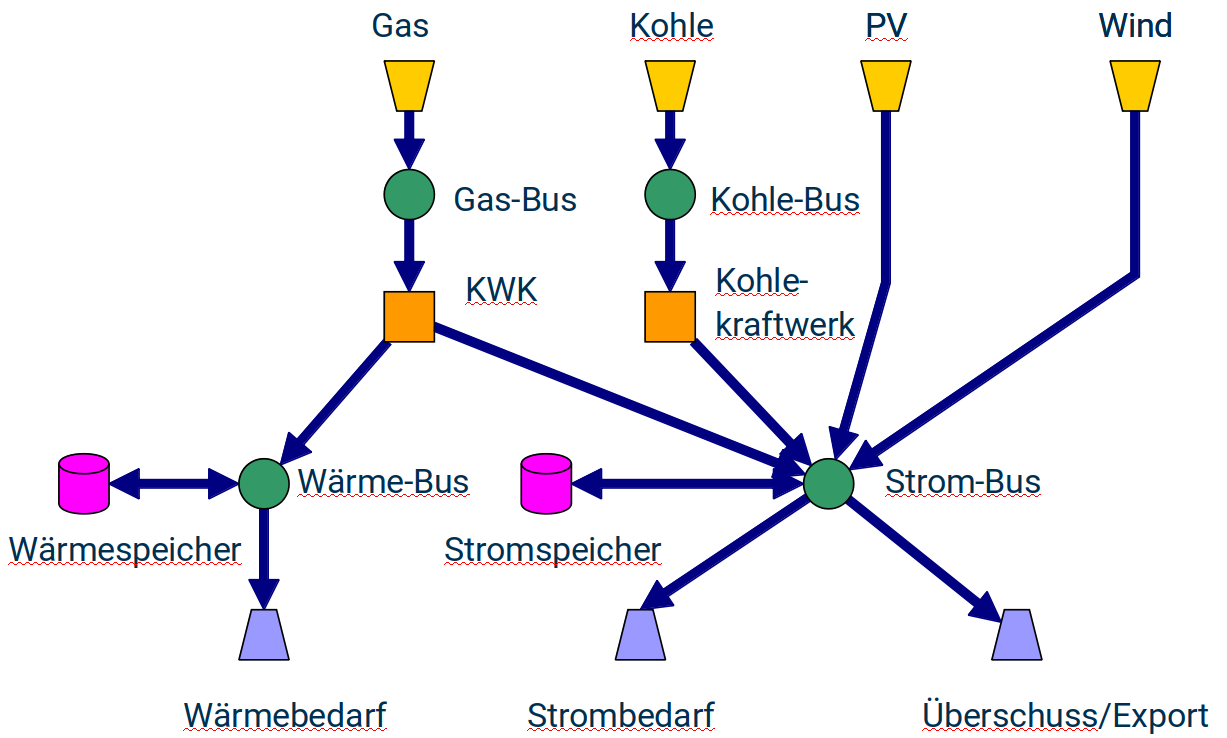

## Create Buses

In [33]:
# resource buses
bus_gas = Bus(label='gas')
bus_coal = Bus(label='coal')

In [34]:
# electricity and heat buses
bus_el = Bus(label='electricity')
bus_th = Bus(label='heat')

## Create components

In [35]:
source_gas = Source(label='source_gas', outputs={bus_gas: Flow(variable_costs=0.035*1e6)}) # EUR/GWh
source_coal = Source(label='source_coal', outputs={bus_coal: Flow(variable_costs=0.02*1e6)})

In [36]:
# Renewable feedin
wind = Source(label='wind', outputs={bus_el: Flow(actual_value=data['wind'],
                                                  nominal_value=60,
                                                  fixed=True)})

pv = Source(label='pv', outputs={bus_el: Flow(actual_value=data['pv'],
                                              nominal_value=43,
                                              fixed=True)})

In [37]:
# Electricity/heat demand
demand_el = Sink(label='demand_el',
                 inputs={bus_el: Flow(nominal_value=85,
                                         actual_value=data['demand_el'],
                                         fixed=True)})

demand_th = Sink(label='demand_th',
                 inputs={bus_th: Flow(nominal_value=40,
                                      actual_value=data['demand_th'],
                                      fixed=True)})

In [38]:
# power plants
pp_coal = Transformer(label='pp_coal',
                      inputs={bus_coal: Flow()},
                      outputs={bus_el: Flow(nominal_value=50,
                                            emission_factor=0.335)},
                      conversion_factors={bus_el: 0.39})

In [39]:
# combined heat and power plant (chp)
chp_gas = Transformer(label='chp_gas',
                      inputs={bus_gas: Flow()},
                      outputs={bus_el: Flow(nominal_value=40,  # does not have any effect and can be omitted
                                            emission_factor=0.202),
                               bus_th: Flow(nominal_value=40)}, # this constraint binds
                      conversion_factors={bus_el: 0.3, bus_th: 0.4})

In [40]:
storage_el = GenericStorage(label='storage_el',
                            nominal_storage_capacity=1000,
                            inputs={bus_el: Flow(nominal_value=9)},
                            outputs={bus_el: Flow(nominal_value=9)},
                            loss_rate=0.01,
                            initial_storage_level=0,
                            max_storage_level=0.9,
                            inflow_conversion_factor=0.9,
                            outflow_conversion_factor=0.9)

storage_th = GenericStorage(label='storage_th',
                            nominal_storage_capacity=1000,
                            inputs={bus_th: Flow(nominal_value=20)},
                            outputs={bus_th: Flow(nominal_value=20)},
                            loss_rate=0.01,
                            initial_storage_level=0,
                            max_storage_level=0.9,
                            inflow_conversion_factor=0.9,
                            outflow_conversion_factor=0.9)

In [41]:
# an excess and a shortage variable can help to avoid infeasible problems
excess_el = Sink(label='excess_el', inputs={bus_el: Flow()})

shortage_el = Source(label='shortage_el',
                     outputs={bus_el: Flow(variable_costs=1e15)})

## Add all to the energysystem

In [42]:
energysystem.add(bus_coal, bus_gas, bus_el, bus_th,
                 source_gas, source_coal,
                 wind, pv, demand_el, demand_th,
                 pp_coal, chp_gas, 
                 storage_el, storage_th,
                 excess_el, shortage_el)

## Create an Optimization Model and solve it

In [43]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver='cbc')

{'Problem': [{'Name': 'unknown', 'Lower bound': 1.482357068e+16, 'Upper bound': 1.482357068e+16, 'Number of objectives': 1, 'Number of constraints': 78843, 'Number of variables': 131401, 'Number of nonzeros': 25938, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 2.52, 'Wallclock time': 2.59, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 54120}}, 'Error rc': 0, 'Time': 2.6113522052764893}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Get results

In [44]:
results_main = outputlib.processing.results(optimization_model)
results_meta = outputlib.processing.meta_results(optimization_model)
params = outputlib.processing.parameter_as_dict(energysystem)

## Have a look at some results

In [45]:
results_meta

{'objective': 1.4823570812975064e+16,
 'problem': {'Name': 'unknown',
  'Lower bound': 1.482357068e+16,
  'Upper bound': 1.482357068e+16,
  'Number of objectives': 1,
  'Number of constraints': 78843,
  'Number of variables': 131401,
  'Number of nonzeros': 25938,
  'Sense': EnumValue(<pyutilib.enum.enum.Enum object at 0x7fd7858fbda0>, 1, 'minimize')},
 'solver': {'Status': EnumValue(<pyutilib.enum.enum.Enum object at 0x7fd7858f6198>, 0, 'ok'),
  'User time': -1.0,
  'System time': 2.52,
  'Wallclock time': 2.59,
  'Termination condition': EnumValue(<pyutilib.enum.enum.Enum object at 0x7fd7858f61d0>, 8, 'optimal'),
  'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.',
  'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 54120}},
  'Error rc': 0,
  'Time': 2.6113522052764893}}

In [46]:
results_main[bus_gas, chp_gas]['sequences'].head()

variable_name,flow
2016-01-01 00:00:00,14.694523
2016-01-01 01:00:00,15.004446
2016-01-01 02:00:00,15.692587
2016-01-01 03:00:00,17.405038
2016-01-01 04:00:00,21.751368


## Pass results to energysystem.results object before saving

In [47]:
energysystem.results['main'] = results_main
energysystem.results['meta'] = results_meta
energysystem.results.keys()

['Problem', 'Solver', 'Solution', 'Main', 'Meta']

In [48]:
energysystem.params = params

## Save results - Dump the energysystem (to ~/home/user/.oemof by default)
Specify path and filename if you do not want to overwrite

In [49]:
energysystem.dump(dpath='/home/jann/Desktop', filename='energy.oemof')

'Attributes dumped to: /home/jann/Desktop/energy.oemof'